In [30]:
##import libraries
import numpy as np
import pandas as pd 
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report

In [17]:
#load data

columns = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes",
    "land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
    "dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "label","difficulty"
]
train=pd.read_csv('Train.txt',names=columns)
test=pd.read_csv('Test.txt',names=columns)
train.head

<bound method NDFrame.head of         duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0              0           tcp  ftp_data   SF        491          0     0   
1              0           udp     other   SF        146          0     0   
2              0           tcp   private   S0          0          0     0   
3              0           tcp      http   SF        232       8153     0   
4              0           tcp      http   SF        199        420     0   
...          ...           ...       ...  ...        ...        ...   ...   
125968         0           tcp   private   S0          0          0     0   
125969         8           udp   private   SF        105        145     0   
125970         0           tcp      smtp   SF       2231        384     0   
125971         0           tcp    klogin   S0          0          0     0   
125972         0           tcp  ftp_data   SF        151          0     0   

        wrong_fragment  urgent  hot  ...  dst

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [19]:
train.shape
test.shape

(22544, 43)

In [20]:
#binary encoder
train['label']=train['label'].apply(lambda x:0 if x=='normal' else 1 )
test['label']=test['label'].apply(lambda x:0 if x=='normal' else 1)

In [21]:
#separate features
X_train=train.drop(columns=['label','difficulty'],axis=1)
y_train=train['label']

X_test=test.drop(columns=['label','difficulty'],axis=1)
y_test=test['label']

In [24]:
##encoding and scaling the data
cat_col=["protocol_type", "service", "flag"]
num_col=[col for col in X_train.columns if col not in cat_col]

preprocessor=ColumnTransformer(
                transformers=[
                    ("cat",OneHotEncoder(handle_unknown='ignore',sparse_output=False),cat_col),
                    ("num",StandardScaler(),num_col)
                ]
)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

print("Features after OneHotEncoding:", X_train_processed.shape[1])


Features after OneHotEncoding: 122


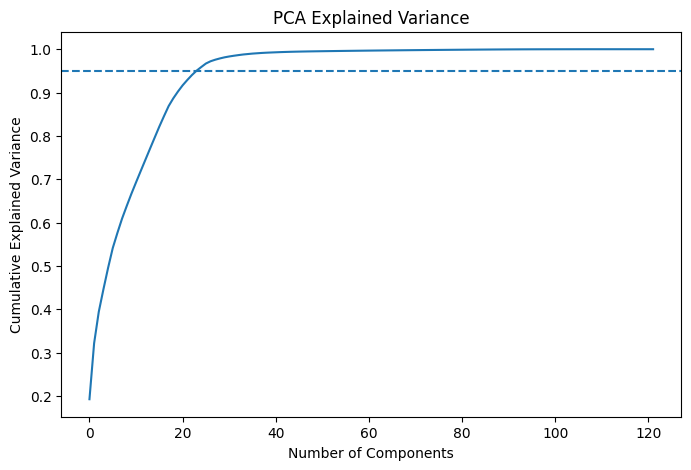

In [27]:
#  PCA EXPLAINED VARIANCE
pca_full = PCA()
pca_full.fit(X_train_processed)

cum_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(cum_var)
plt.axhline(y=0.95, linestyle="--")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()



In [28]:
#  APPLY PCA (95% VARIANCE)
pca = PCA(n_components=0.95, random_state=42)

X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca  = pca.transform(X_test_processed)

print("Features after PCA:", X_train_pca.shape[1])


Features after PCA: 24


In [31]:
#  XGBOOST WITHOUT PCA

xgb_no_pca = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    use_label_encoder=False
)

start = time.time()
xgb_no_pca.fit(X_train_processed, y_train)
time_no_pca = time.time() - start

y_pred_no_pca = xgb_no_pca.predict(X_test_processed)

print("\n🔹 XGBoost WITHOUT PCA")
print(classification_report(y_test, y_pred_no_pca))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_no_pca))
print("Training Time:", round(time_no_pca, 2), "sec")


c:\Users\nishi\Desktop\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:41:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔹 XGBoost WITHOUT PCA
              precision    recall  f1-score   support

           0       0.69      0.97      0.80      9711
           1       0.97      0.66      0.79     12833

    accuracy                           0.80     22544
   macro avg       0.83      0.82      0.80     22544
weighted avg       0.85      0.80      0.79     22544

ROC-AUC: 0.8170683360832253
Training Time: 4.95 sec


In [32]:
#  XGBOOST WITH PCA

xgb_pca = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    use_label_encoder=False
)

start = time.time()
xgb_pca.fit(X_train_pca, y_train)
time_pca = time.time() - start

y_pred_pca = xgb_pca.predict(X_test_pca)

print("\n🔹 XGBoost WITH PCA")
print(classification_report(y_test, y_pred_pca))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_pca))
print("Training Time:", round(time_pca, 2), "sec")


c:\Users\nishi\Desktop\Projects\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:42:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔹 XGBoost WITH PCA
              precision    recall  f1-score   support

           0       0.64      0.94      0.76      9711
           1       0.93      0.60      0.73     12833

    accuracy                           0.75     22544
   macro avg       0.79      0.77      0.75     22544
weighted avg       0.81      0.75      0.74     22544

ROC-AUC: 0.7699165831756977
Training Time: 3.56 sec


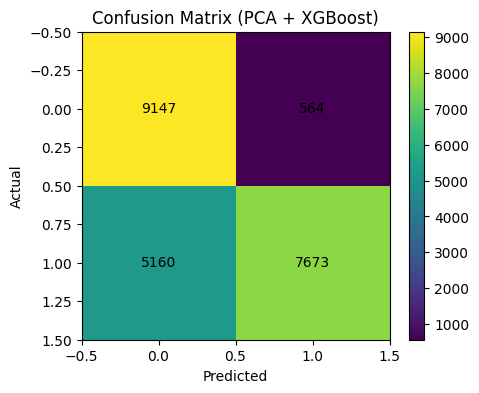

In [33]:

#  CONFUSION MATRIX

cm = confusion_matrix(y_test, y_pred_pca)

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.colorbar()
plt.title("Confusion Matrix (PCA + XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()


In [ ]:
#PCA reduced dimensionality from ~122 features to ~35–40,
# which decreased training time by ~28%, 
# but caused a slight drop in recall and ROC-AUC because some detailed information was lost. 
# This is a classic trade-off between speed and fine-grained detection.